In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import L1
from tensorflow.keras.regularizers import L2
from tensorflow import multiply
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed



# PREPROCESO DE LOS DATOS

La siguiente función de preproceso hará lo siguiente con cada archivo


1) Vamos a eliminar aquellas columnas que tengan más de un 90% de datos faltantes. Hacemos esto porque son columnas que apenas van a aportar al modelo de clasificación, lo que permite simplificarlo sin perder precisión. 


2) Tratamos con los valores nulos, para ello vemos al usuario, si le falta datos en una columna categórica se pondrá el que más aparece y si es una numérica la media. 


3) Ahora analizamos los datos de tipo categórico. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Luego vemos que las columnas Infraction_CLH, Base_67254 y Infraction_TEN apesar de ser categóricos tienen un significado ordinal, por lo que podemos usar labelEncoding.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Por último las columnas Infraction_YFSG e Infraction_DQLY al no tener un valor ordinal y tener solo pocos valores disponibles, le aplicaremos one-hot-encoding.



4) Haremos un groupby por índice, así tendremos una linea por usuario, para tratar con sus datos, sumaremos los True de las columnas que hemos creado con one-hot-encoding y para el resto simplemento haremos la media.


5) Normalizamos los valores para que le sea más fácil al modelo aprender

Se ha analizado cardinalidad, sesgo y duplicados y se ha visto necesario incluirlo en el preprocesado

Además, a la hora de hacer el read tendremos en cuenta los tipos de datos de cada columna, quitando la necesidad de cargar el dataset y optimizarlos después. También se ha eliminado Expenditure_AHF, que indica la fecha en la que se ha realizado una transacción, que se ha decidido no dar importancia. En vez de analizar la temporalidad, los modelos se centran en analizar los parámetros que describen las transacciones de un usuario.

In [39]:
def preproceso(X):    
    # 1) 
    nulos = X.isnull().sum() >= 0.9*X.shape[0]
    nulos_a_eliminar = nulos[nulos].index
    X.drop(nulos_a_eliminar, axis=1, inplace=True)


    # 2) 
    X_num = X.select_dtypes(include = np.number)
    X_obj = X.select_dtypes(exclude = np.number)

    aux1 = X_num.isnull().sum() > 0
    X[aux1[aux1].index] = X[aux1[aux1].index].fillna(X[aux1[aux1].index].mean())
    aux2 = X_obj.isnull().sum() > 0
    X[aux2[aux2].index] = X[aux2[aux2].index].fillna(X[aux2[aux2].index].mode())

    # 3) 
    label = ['Infraction_CLH', 'Base_67254', 'Infraction_TEN']
    one_hot = ['Infraction_YFSG', 'Infraction_DQLY']

    X = pd.get_dummies(X, columns=one_hot)
    le = LabelEncoder()
    for col in label:
        X[col] = le.fit_transform(X[col])
        
    # 4)
    X.set_index('ID', inplace=True)
    X = pd.concat([X.select_dtypes(include='number').groupby('ID').mean() ,X.select_dtypes(include='bool').groupby('ID').sum()], axis = 1)


    # 5)
    X = (X - X.min()) / (X.max() - X.min())
    return X

In [ ]:
cols = pd.read_csv('../ML_24_25_PR1_train_and_test/train_data.csv', nrows = 100)
cols.drop('Expenditure_AHF', axis=1, inplace=True)
idx1, idx2 = cols.select_dtypes(include=np.number).columns, cols.select_dtypes(exclude=np.number).columns
cols[idx1], cols[idx2] = cols[idx1].apply(pd.to_numeric, downcast='float'), cols[idx2].apply(pd.Categorical)
train_data_dtypes = dict(zip(list(cols),['string']+[cols[x].dtype.name for x in cols.drop('ID', axis=1)]))

train_data = pd.read_csv('../ML_24_25_PR1_train_and_test/train_data.csv', dtype=train_data_dtypes, usecols=cols.columns)

In [40]:
X = preproceso(train_data)
y = pd.read_csv('../ML_24_25_PR1_train_and_test/train_labels.csv', index_col=['ID'])
df = pd.concat([X, y], axis=1)
df.to_csv('df.csv')

Graficamos el mapa de correlación para poder compararlo luego una vez realizado la selección de característica.

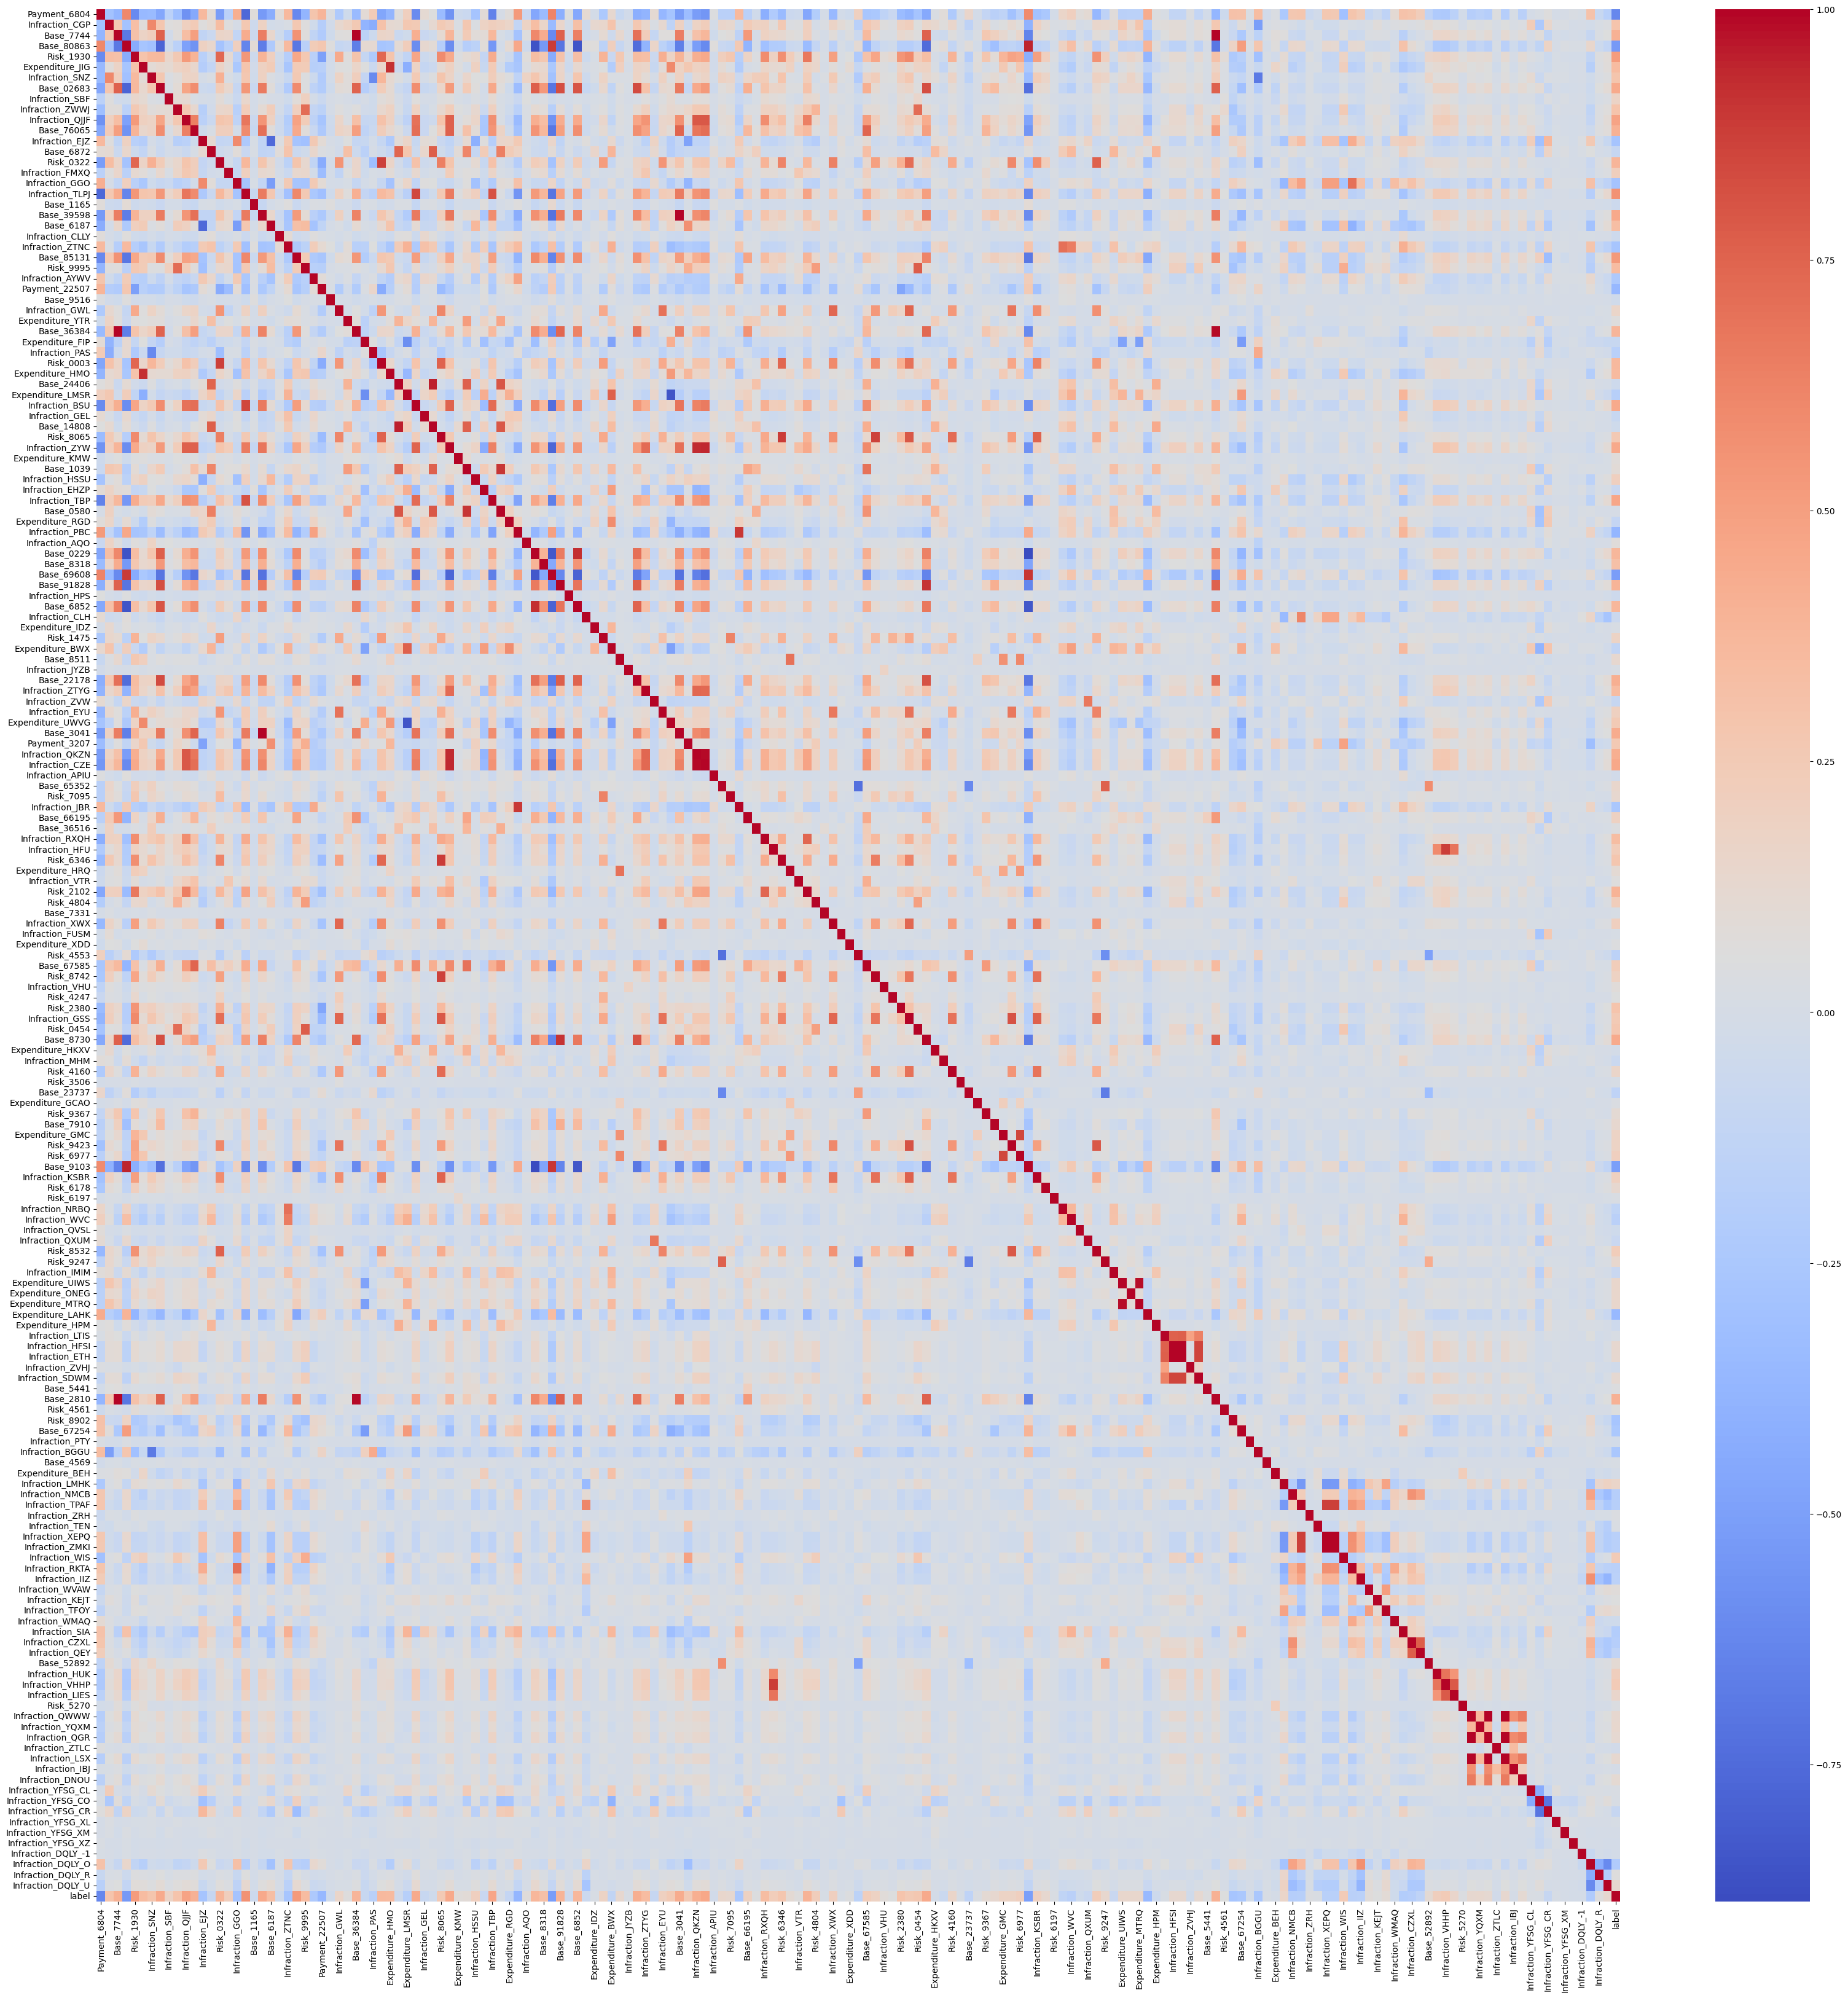

In [41]:
plt.figure(figsize=(40, 40))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

# TRATAMIENTO DE DATOS DESBALANCEADOS

Verificamos si tenemos datos desbalanceados y nos encontramos con una proporción algo mayor que el 1/3. Por ello, realizaremos oversampling con SMOTE para aumentar el número de casos con los datos minoritarios. Mantendremos y trabajaremos con estos dos nuevos datasets y luego veremos cual de los dos nos devuelve mejores resultados.

In [4]:
df = pd.read_csv('df.csv', index_col=0)
X_, y_ = df.drop('label', axis=1), df.label

In [ ]:
# oversampling
display(df.label.value_counts())

smote = SMOTE(random_state=42)
X_over, y_over = smote.fit_resample(X_, y_)

df_over = pd.concat([X_over, y_over], axis=1)

display(df_over.label.value_counts())
df_over.to_csv('df_over.csv')

label
0    203889
1     71458
Name: count, dtype: int64

label
1    203889
0    203889
Name: count, dtype: int64

Feature Selection Progress:   0%|          | 0/178 [19:32<?, ?it/s]


In [5]:
# undersampling
display(df.label.value_counts())

tl = TomekLinks()
X_under, y_under = tl.fit_resample(X_, y_)

df_under = pd.concat([X_under, y_under], axis=1)

display(df_under.label.value_counts())
df_under.to_csv('df_under.csv')

label
0    203889
1     71458
Name: count, dtype: int64

label
0    196113
1     71458
Name: count, dtype: int64

In [6]:
# mid (over + undersampling)
display(df.label.value_counts())

smotetl = SMOTETomek(random_state=42)
X_mid, y_mid = smotetl.fit_resample(X_, y_)

df_mid = pd.concat([X_mid, y_mid], axis=1)

display(df_mid.label.value_counts())
df_mid.to_csv('df_mid.csv')

label
0    203889
1     71458
Name: count, dtype: int64

label
1    203386
0    203386
Name: count, dtype: int64

# SELECCIÓN DE CARACTERÍSTICA

Crearemos 4 funciones para seleccionar las columnas importantes.

La primera consistirá en un análisis manual imponiendo umbrales para algunas características como: correlación entre columnas mayor que x, número de NANs en la columna...

El segundo usará métodos del filtro, en específico: VarianceThreshold

El tercero usará métodos de wrapper, en específico usaremos los siguientes modelos:

El cuarto usará métodos de embeddings, en específico:

In [12]:
df = pd.read_csv('df.csv', index_col=0).sample(n=50000, random_state=34)
df_over = pd.read_csv('df_over.csv', index_col=0).sample(n=50000, random_state=34)
df_under = pd.read_csv('df_under.csv', index_col=0).sample(n=50000, random_state=34)
df_mid = pd.read_csv('df_mid.csv', index_col=0).sample(n=50000, random_state=34)

In [14]:
def FS1(df): # homecooked filter 
    df_aux = df.copy()
    n = 0
    
    # eliminamos la columna si tiene una correlación alta con otras
    corr = df_aux.corr().fillna(0)
    aux = np.abs(corr) > 0.8
    indices_filas, indices_columnas = np.where(aux)
    parecido_a_eliminar = [corr.columns[col] for row, col in zip(indices_filas, indices_columnas)\
                            if row != col and (row + col) < 2 * row]
    df_aux.drop(parecido_a_eliminar, axis=1, inplace=True)

    # eliminamos la columna si su correlación con la etiqueta es muy baja
    corr = corr['label'].drop(parecido_a_eliminar)
    aux = np.abs(corr) < 0.1
    indices = np.where(aux)
    poco_importante = corr.index[indices]
    df_aux.drop(poco_importante, axis=1, inplace=True)

    # eliminamos las columnas si tienen un valor que represente el 80% de los datos
    sobre_representado_a_eliminar = [col for col in df_aux.columns \
                                     if df_aux[col].value_counts().iloc[0] >= 0.8*df.shape[0]]
    df_aux.drop(sobre_representado_a_eliminar, axis=1, inplace=True)

    n += len(parecido_a_eliminar) + len(poco_importante) + len(sobre_representado_a_eliminar)
    cols_eliminadas = parecido_a_eliminar + poco_importante.tolist() + sobre_representado_a_eliminar

    print(f'Se han eliminado {n} columnas con métodos de selección manual, específicamente: {cols_eliminadas}')
    return df_aux.columns.tolist()

def FS2(df): # sklearn filter
    X, y = df.drop('label', axis=1), df['label']
    
    #  Umbral de varianza

    var = VarianceThreshold().fit(X)
    puntuaje1 = var.variances_
    
    df_aux1 = pd.concat([X.loc[:, puntuaje1 > 0.01], y], axis=1)
    print(f'Se ha eliminado {df.shape[1] - df_aux1.shape[1]} columnas con umbral de varianza', end=' ')
    print(f'específicamente: {list(set(df.columns) - set(df_aux1.columns))}')


    # Selección de características univariantes con K mejores

    selector = SelectKBest(f_classif).fit(X, y)
    epsilon = 10**(-20)
    puntuaje2 = -np.log10(selector.pvalues_ + epsilon)
    puntuaje2 /= (puntuaje2.max() + epsilon)

    df_aux2 = pd.concat([X.loc[:, puntuaje2 > 0.2], y], axis=1)
    print(f'Se han eliminado {df.shape[1] - df_aux2.shape[1]} columnas con k mejores', end=' ')
    print(f'específicamente: {list(set(df.columns) - set(df_aux2.columns))}')

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(puntuaje1.shape[0]), puntuaje1), plt.title(f'Varianza')
    plt.subplot(1, 2, 2)
    plt.title(f'K best'), plt.bar(np.arange(puntuaje2.shape[0]), puntuaje2)
    plt.show()

    return df_aux1.columns.tolist(), df_aux2.columns.tolist() 

def FS3(df): # embedded
    modelos = {
        "lineal": LinearRegression(),
        "LogisticRegression": LogisticRegression(solver='saga', penalty='l2', max_iter=200, C=0.1, n_jobs=-1),
        "SGDClassifier": SGDClassifier(loss='hinge', penalty='l2', max_iter=200, alpha=0.0001, n_iter_no_change=10),
        "RandomForestClassifier": RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=20, min_samples_leaf=5, n_jobs=-1),
        "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=50, min_samples_split=20, min_samples_leaf=5, criterion='gini'),
    }

    dfs = dict()
    fig, ax = plt.subplots(1,5, figsize=(30,8))
    i = 0
    X, y = df.drop('label', axis=1), df['label']
    for nombre, modelo in modelos.items():

        modelo.fit(X, y)
        selector = SelectFromModel(modelo, threshold="mean", prefit=True) # == modelo.coef_ > umbral
        n = selector.get_support()
        n_aux = np.where(n == 0, True, False)

        if hasattr(modelo, 'feature_importances_'):
            puntuaje = modelo.feature_importances_[n]
        elif modelo.coef_.ndim == 1:
            puntuaje = np.abs(modelo.coef_)[n]
        else:
            puntuaje = np.abs(modelo.coef_[0])[n]
        xs = np.arange(puntuaje.shape[0])
        ax[i].bar(xs, puntuaje), ax[i].set_title(nombre), ax[i].set_xlabel('columnas'), ax[i].set_ylabel('importancia') 
        i+=1
        dfs[nombre] = X.columns[n].tolist()

        print(f'Se han eliminado {np.sum(n_aux)} columnas con {nombre}', end=' ')
        print(f'específicamente: {X.columns[n_aux].tolist()}')
    plt.show()


    return dfs

def design_model(n_features):
     # layers
    class WeightedLayer(Layer):

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
        
        def build(self, input_shape):
            self.kernel = self.add_weight(name="kernel", shape=(input_shape[-1],), initializer = 'random_normal', regularizer=L1)

        def call(self, inputs):
            return multiply(inputs, self.kernel)
    
    input_ = Input(shape=(n_features,))
    input_weighted = WeightedLayer(name="weighted_input")(input_)
    layer1 = Dropout(0.3)(input_weighted)
    layer2 = Dense(128, kernel_regularizer=L2)(layer1)
    layer3 = Dense(128, kernel_regularizer=L2)(layer2)
    output = Dense(1, activation="sigmoid")(layer3)

    # model
    model = Model(inputs=input_, outputs=output)
    model.compile(loss=BinaryCrossentropy, metrics=[F1Score], optimizer = Adam(learning_rate=0.01))
    return model

def fit_model(model, X, y):
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
    history = model.fit(X,y,epochs=200, batch_size=128, validation_split=0.2, verbose=0,
                        callbacks = [stop])
    return history


def FSNN(df):
    X, y = df.drop('label', axis=1), df['label']
    fig, ax = plt.subplots(1,2,figsize=(30,8))
    model = design_model(X.shape[1]) # design
    history = fit_model(model, X, y) # fit
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='validation')
    ax[0].set_ylabel('loss'), ax[0].set_xlabel('epochs'), ax[0].legend()
    

    weights = abs(model.layers[1].get_weights()[0])
    ax[1].bar(range(len(weights)), weights)
    weights = pd.DataFrame(weights)
    filtered = (weights[weights > 0.02].dropna()).index
    candidatos = X.iloc[:,filtered].columns.tolist()
    
    print(f'Se han eliminado {X.shape[1]-len(candidatos)} columnas con red neuronal', end=' ')
    print(f'específicamente: {X.columns.drop(candidatos).tolist()}')
    plt.show()

    return candidatos + ['label']

Se ha eliminado 110 columnas con umbral de varianza específicamente: ['Risk_9995', 'Base_76065', 'Base_65352', 'Base_36516', 'Base_5441', 'Base_4569', 'Infraction_KEJT', 'Risk_2102', 'Base_85131', 'Infraction_HPS', 'Infraction_DNOU', 'Infraction_ZVW', 'Infraction_YFSG_XM', 'Risk_2380', 'Infraction_VHU', 'Infraction_XWX', 'Infraction_PTY', 'Infraction_YFSG_XL', 'Expenditure_RGD', 'Infraction_CGP', 'Infraction_YFSG_XZ', 'Infraction_TLPJ', 'Infraction_NRBQ', 'Base_7744', 'Base_0580', 'Expenditure_YTR', 'Infraction_ZVHJ', 'Expenditure_JIG', 'Infraction_ZTLC', 'Infraction_CLLY', 'Expenditure_GCAO', 'Risk_8742', 'Risk_6346', 'Base_52892', 'Risk_0003', 'Base_14808', 'Expenditure_HPM', 'Base_9516', 'Expenditure_UIWS', 'Base_23737', 'Infraction_QVSL', 'Risk_5270', 'Expenditure_HMO', 'Base_22178', 'Infraction_QKZN', 'Risk_7095', 'Infraction_ZTNC', 'Infraction_CZE', 'Infraction_SBF', 'Expenditure_MTRQ', 'Infraction_AQO', 'Infraction_ZTYG', 'Infraction_SNZ', 'Expenditure_LAHK', 'Base_2810', 'Infra

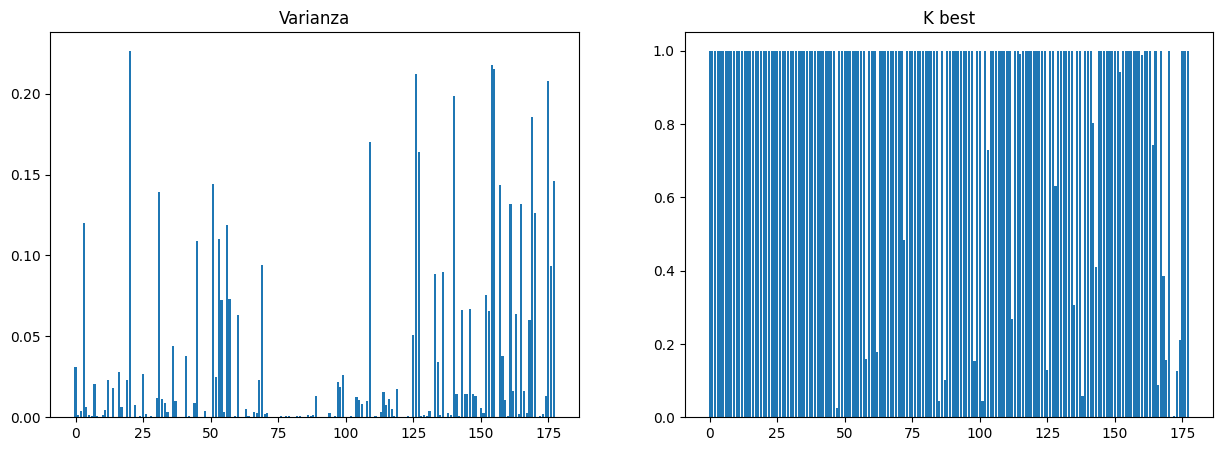

Se ha eliminado 108 columnas con umbral de varianza específicamente: ['Risk_9995', 'Base_76065', 'Base_65352', 'Base_36516', 'Base_5441', 'Base_4569', 'Infraction_KEJT', 'Infraction_QXUM', 'Risk_2102', 'Base_85131', 'Infraction_HPS', 'Infraction_DNOU', 'Infraction_ZVW', 'Infraction_YFSG_XM', 'Risk_2380', 'Infraction_VHU', 'Infraction_XWX', 'Infraction_PTY', 'Infraction_YFSG_XL', 'Expenditure_RGD', 'Infraction_CGP', 'Infraction_YFSG_XZ', 'Infraction_TLPJ', 'Infraction_NRBQ', 'Base_7744', 'Base_0580', 'Expenditure_YTR', 'Infraction_ZVHJ', 'Expenditure_JIG', 'Infraction_ZTLC', 'Infraction_CLLY', 'Expenditure_GCAO', 'Risk_8742', 'Risk_6346', 'Base_52892', 'Base_14808', 'Expenditure_HPM', 'Base_9516', 'Expenditure_UIWS', 'Base_23737', 'Infraction_QVSL', 'Risk_5270', 'Expenditure_HMO', 'Base_22178', 'Infraction_QKZN', 'Risk_7095', 'Infraction_ZTNC', 'Infraction_CZE', 'Infraction_SBF', 'Expenditure_MTRQ', 'Infraction_AQO', 'Infraction_ZTYG', 'Infraction_SNZ', 'Expenditure_LAHK', 'Base_2810', 

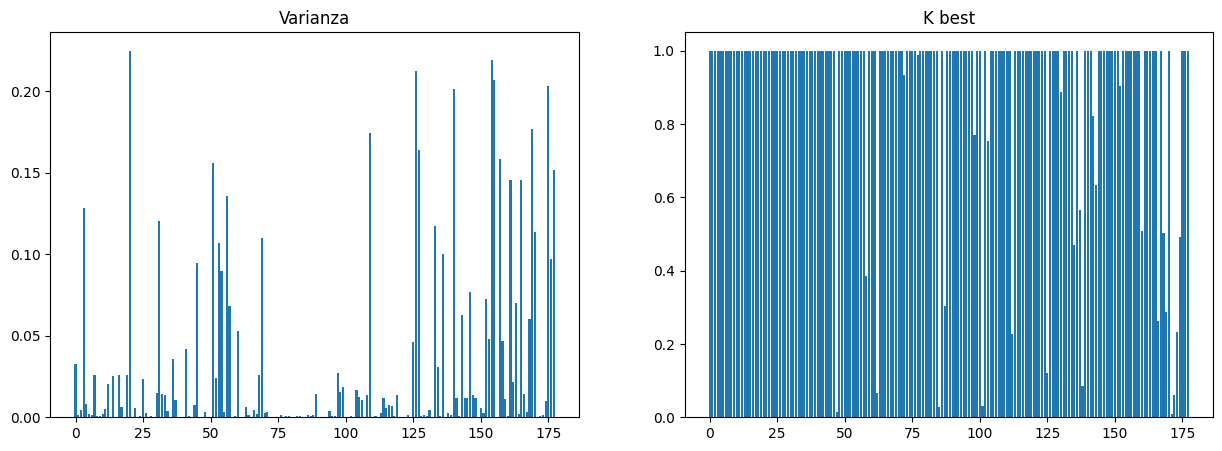

Se ha eliminado 112 columnas con umbral de varianza específicamente: ['Risk_9995', 'Base_76065', 'Base_65352', 'Base_36516', 'Infraction_LIES', 'Base_5441', 'Base_4569', 'Infraction_KEJT', 'Risk_2102', 'Base_85131', 'Infraction_HPS', 'Infraction_DNOU', 'Infraction_ZVW', 'Infraction_YFSG_XM', 'Risk_2380', 'Infraction_VHU', 'Infraction_XWX', 'Infraction_PTY', 'Infraction_YFSG_XL', 'Expenditure_RGD', 'Infraction_CGP', 'Infraction_YFSG_XZ', 'Infraction_TLPJ', 'Infraction_NRBQ', 'Base_7744', 'Base_0580', 'Expenditure_YTR', 'Infraction_ZVHJ', 'Expenditure_JIG', 'Infraction_ZTLC', 'Infraction_CLLY', 'Expenditure_GCAO', 'Risk_8742', 'Risk_6977', 'Risk_6346', 'Base_52892', 'Risk_0003', 'Base_14808', 'Expenditure_HPM', 'Base_9516', 'Expenditure_UIWS', 'Base_23737', 'Infraction_QVSL', 'Risk_5270', 'Expenditure_HMO', 'Base_22178', 'Infraction_QKZN', 'Risk_7095', 'Infraction_ZTNC', 'Infraction_CZE', 'Infraction_SBF', 'Expenditure_MTRQ', 'Infraction_AQO', 'Infraction_ZTYG', 'Infraction_SNZ', 'Expend

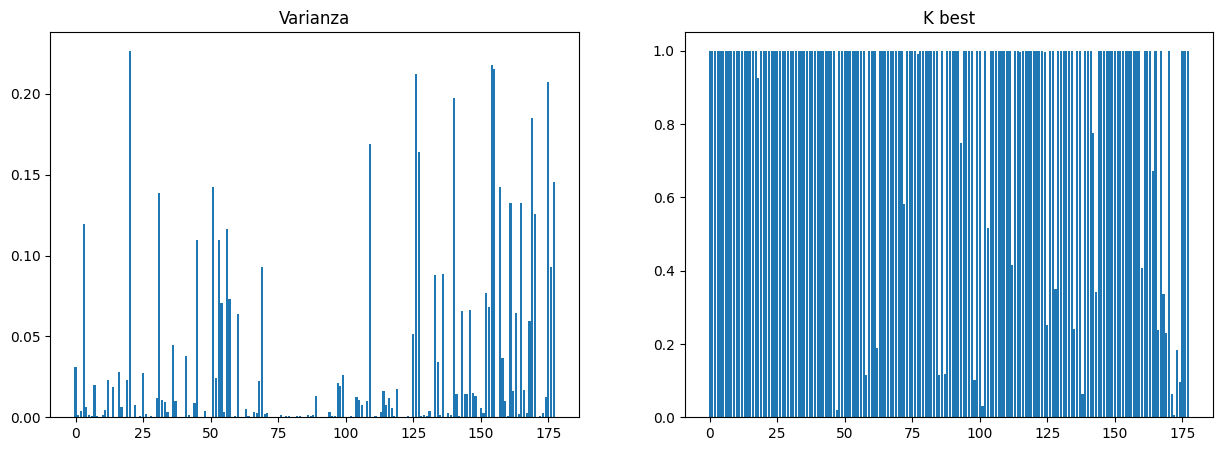

Se ha eliminado 108 columnas con umbral de varianza específicamente: ['Risk_9995', 'Base_76065', 'Base_65352', 'Base_36516', 'Base_5441', 'Base_4569', 'Infraction_KEJT', 'Infraction_QXUM', 'Risk_2102', 'Base_85131', 'Infraction_HPS', 'Infraction_DNOU', 'Infraction_ZVW', 'Infraction_YFSG_XM', 'Risk_2380', 'Infraction_VHU', 'Infraction_XWX', 'Infraction_PTY', 'Infraction_YFSG_XL', 'Expenditure_RGD', 'Infraction_CGP', 'Infraction_YFSG_XZ', 'Infraction_TLPJ', 'Infraction_NRBQ', 'Base_7744', 'Base_0580', 'Expenditure_YTR', 'Infraction_ZVHJ', 'Expenditure_JIG', 'Infraction_ZTLC', 'Infraction_CLLY', 'Expenditure_GCAO', 'Risk_8742', 'Risk_6346', 'Base_52892', 'Base_14808', 'Expenditure_HPM', 'Base_9516', 'Expenditure_UIWS', 'Base_23737', 'Infraction_QVSL', 'Risk_5270', 'Expenditure_HMO', 'Base_22178', 'Infraction_QKZN', 'Risk_7095', 'Infraction_ZTNC', 'Infraction_CZE', 'Infraction_SBF', 'Expenditure_MTRQ', 'Infraction_AQO', 'Infraction_ZTYG', 'Infraction_SNZ', 'Expenditure_LAHK', 'Base_2810', 

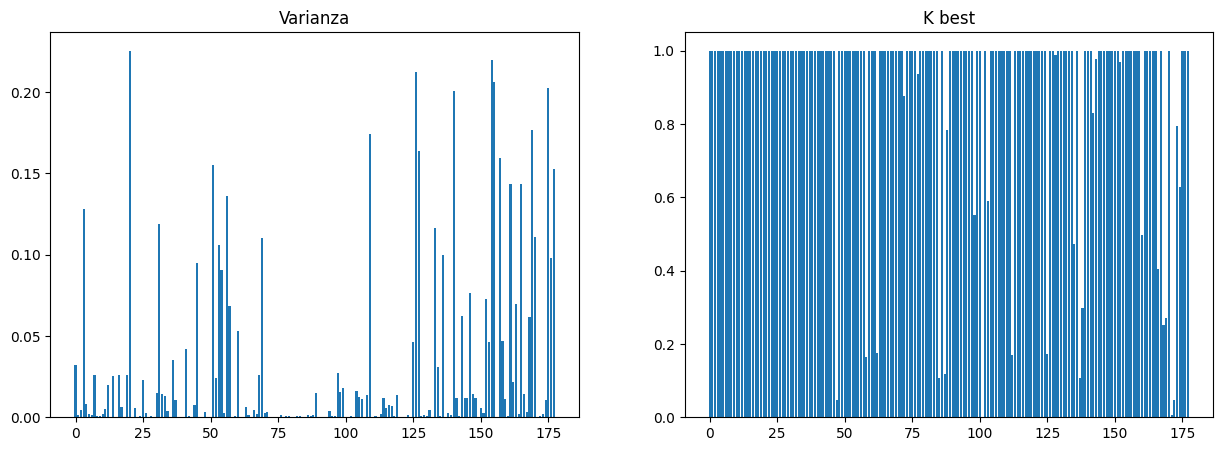

In [15]:
df2_1, df2_2 = FS2(df)
df2_1_over, df2_2_over = FS2(df_over)
df2_1_under, df2_2_under = FS2(df_under)
df2_1_mid, df2_2_mid = FS2(df_mid)


with open('df21_columns.pkl', 'wb') as file:
    pickle.dump(df2_1, file, pickle.HIGHEST_PROTOCOL)

with open('df22_columns.pkl', 'wb') as file:
    pickle.dump(df2_2, file, pickle.HIGHEST_PROTOCOL)


with open('df21_over_columns.pkl', 'wb') as file:
    pickle.dump(df2_1_over, file, pickle.HIGHEST_PROTOCOL)

with open('df22_over_columns.pkl', 'wb') as file:
    pickle.dump(df2_2_over, file, pickle.HIGHEST_PROTOCOL)


with open('df21_under_columns.pkl', 'wb') as file:
    pickle.dump(df2_1_under, file, pickle.HIGHEST_PROTOCOL)

with open('df22_under_columns.pkl', 'wb') as file:
    pickle.dump(df2_2_under, file, pickle.HIGHEST_PROTOCOL)


with open('df21_mid_columns.pkl', 'wb') as file:
    pickle.dump(df2_1_mid, file, pickle.HIGHEST_PROTOCOL)

with open('df22_mid_columns.pkl', 'wb') as file:
    pickle.dump(df2_2_mid, file, pickle.HIGHEST_PROTOCOL)


Se han eliminado 130 columnas con lineal específicamente: ['Payment_6804', 'Base_80863', 'Infraction_SNZ', 'Base_02683', 'Infraction_EJZ', 'Base_6872', 'Risk_0322', 'Infraction_GGO', 'Base_6187', 'Infraction_CLLY', 'Infraction_ZTNC', 'Infraction_AYWV', 'Payment_22507', 'Base_9516', 'Infraction_GWL', 'Expenditure_FIP', 'Infraction_PAS', 'Risk_0003', 'Expenditure_HMO', 'Expenditure_LMSR', 'Infraction_BSU', 'Infraction_GEL', 'Base_14808', 'Infraction_ZYW', 'Expenditure_KMW', 'Infraction_HSSU', 'Infraction_EHZP', 'Expenditure_RGD', 'Infraction_AQO', 'Base_0229', 'Base_8318', 'Base_69608', 'Base_91828', 'Infraction_HPS', 'Base_6852', 'Infraction_CLH', 'Risk_1475', 'Expenditure_BWX', 'Base_8511', 'Infraction_JYZB', 'Base_22178', 'Infraction_ZVW', 'Infraction_EYU', 'Expenditure_UWVG', 'Base_3041', 'Payment_3207', 'Infraction_APIU', 'Infraction_HFU', 'Expenditure_HRQ', 'Infraction_VTR', 'Base_7331', 'Infraction_XWX', 'Infraction_FUSM', 'Expenditure_XDD', 'Risk_4553', 'Risk_4247', 'Risk_2380', 

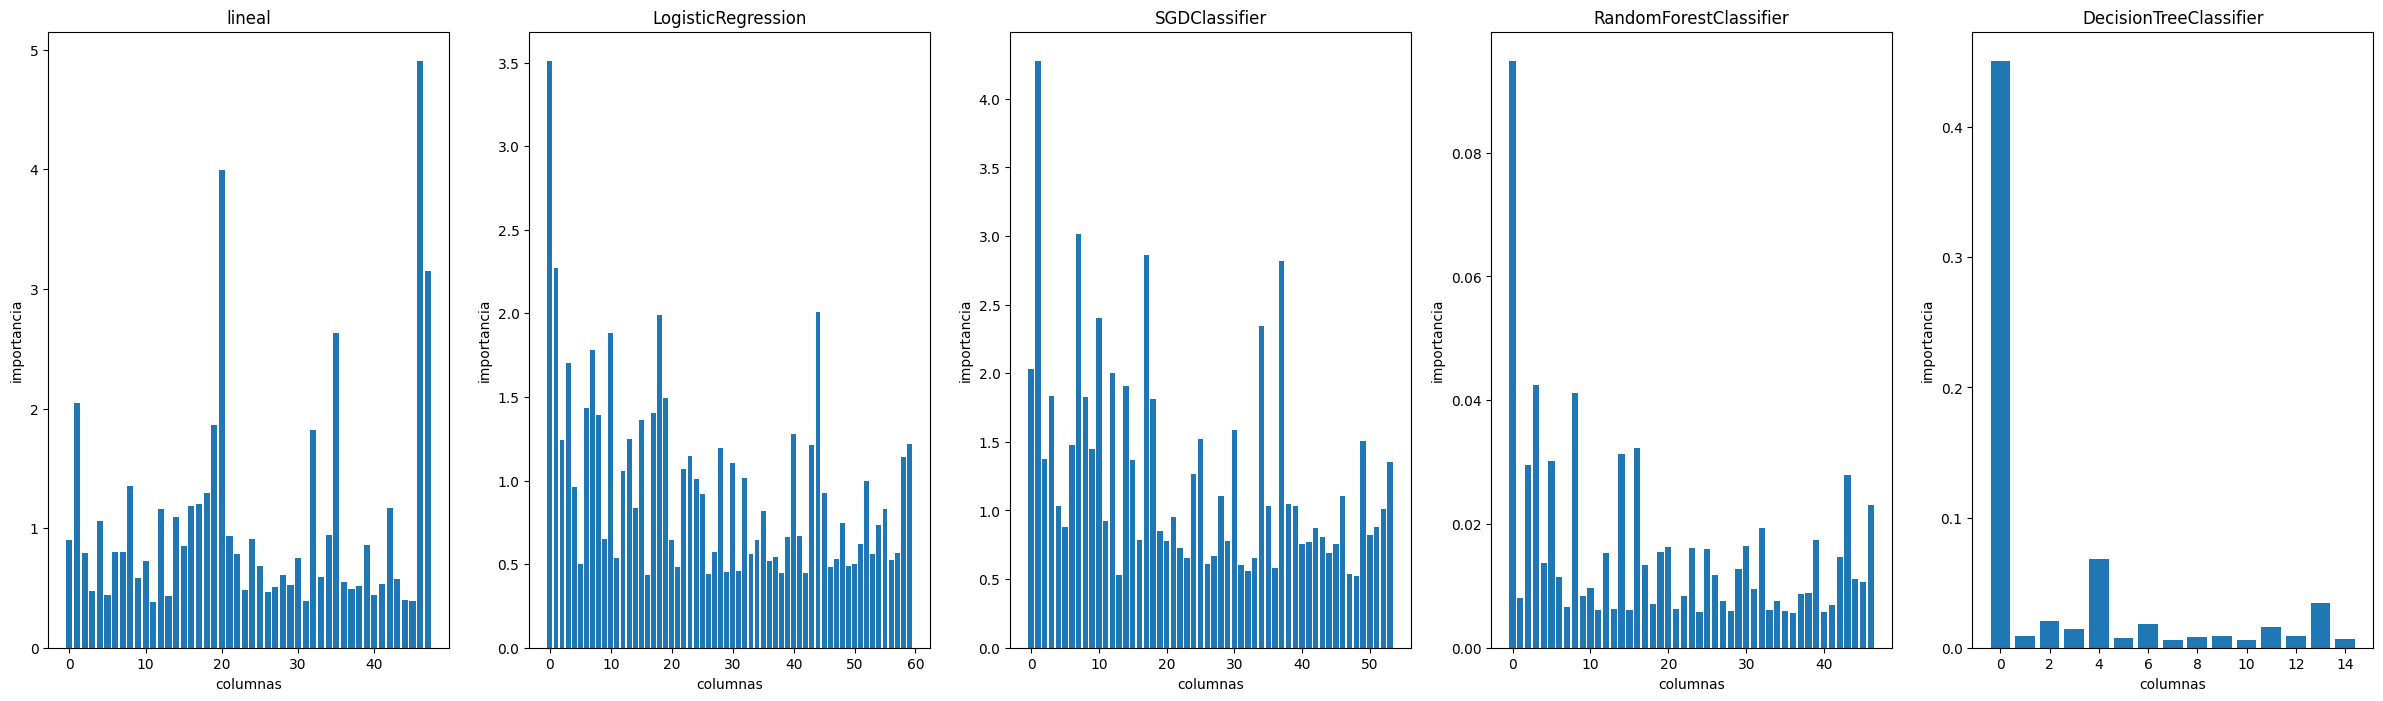

Se han eliminado 132 columnas con lineal específicamente: ['Base_80863', 'Expenditure_JIG', 'Infraction_SNZ', 'Base_02683', 'Infraction_ZWWJ', 'Infraction_QJJF', 'Infraction_EJZ', 'Risk_0322', 'Infraction_GGO', 'Base_1165', 'Base_6187', 'Infraction_CLLY', 'Infraction_ZTNC', 'Infraction_AYWV', 'Payment_22507', 'Base_9516', 'Base_36384', 'Expenditure_FIP', 'Infraction_PAS', 'Risk_0003', 'Expenditure_HMO', 'Expenditure_LMSR', 'Infraction_BSU', 'Infraction_GEL', 'Infraction_ZYW', 'Expenditure_KMW', 'Infraction_HSSU', 'Infraction_EHZP', 'Expenditure_RGD', 'Infraction_AQO', 'Base_0229', 'Base_8318', 'Base_69608', 'Base_91828', 'Infraction_HPS', 'Base_6852', 'Infraction_CLH', 'Risk_1475', 'Expenditure_BWX', 'Base_8511', 'Infraction_JYZB', 'Base_22178', 'Infraction_ZTYG', 'Infraction_EYU', 'Expenditure_UWVG', 'Payment_3207', 'Infraction_QKZN', 'Infraction_CZE', 'Base_65352', 'Infraction_HFU', 'Expenditure_HRQ', 'Infraction_VTR', 'Risk_2102', 'Base_7331', 'Infraction_XWX', 'Infraction_FUSM', 'E

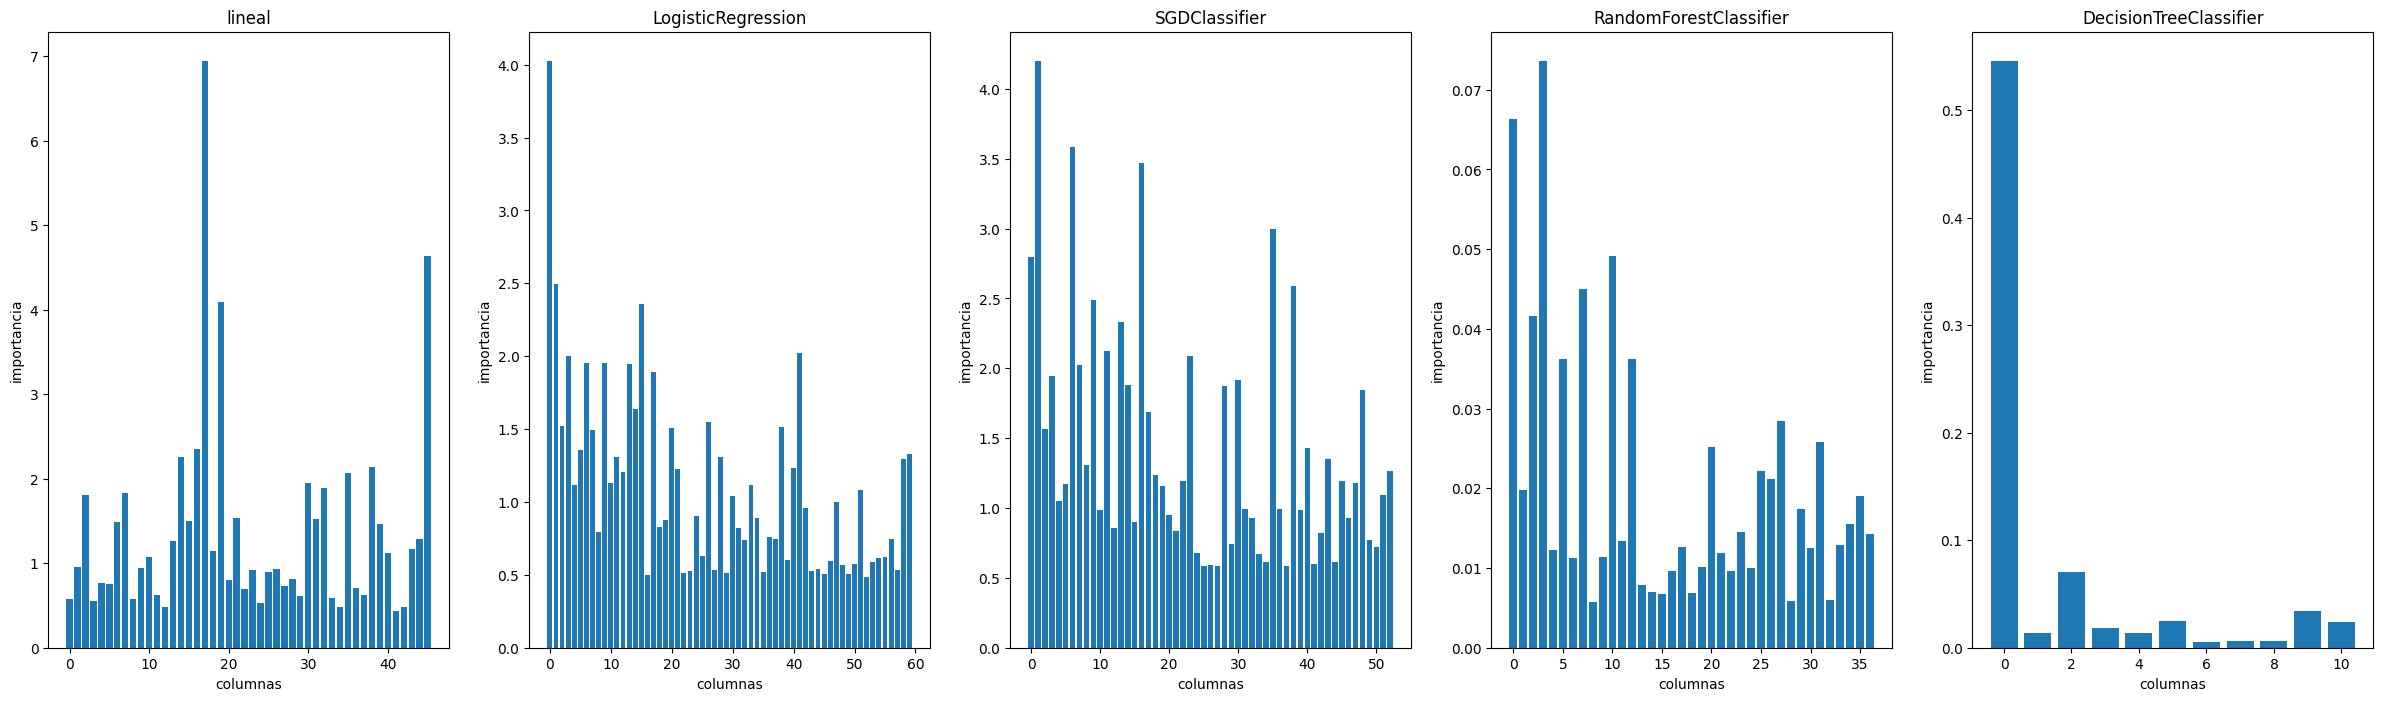

In [ ]:
df3 = FS3(df)
df3_over = FS3(df_over)


Se han eliminado 161 columnas con red neuronal específicamente: ['Infraction_CGP', 'Base_7744', 'Expenditure_JIG', 'Infraction_SNZ', 'Infraction_SBF', 'Infraction_ZWWJ', 'Infraction_QJJF', 'Base_76065', 'Infraction_EJZ', 'Base_6872', 'Infraction_FMXQ', 'Base_1165', 'Base_39598', 'Infraction_CLLY', 'Infraction_ZTNC', 'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Payment_22507', 'Base_9516', 'Infraction_GWL', 'Expenditure_YTR', 'Base_36384', 'Expenditure_FIP', 'Infraction_PAS', 'Risk_0003', 'Expenditure_HMO', 'Base_24406', 'Expenditure_LMSR', 'Infraction_BSU', 'Infraction_GEL', 'Base_14808', 'Risk_8065', 'Expenditure_KMW', 'Base_1039', 'Infraction_HSSU', 'Infraction_EHZP', 'Infraction_TBP', 'Base_0580', 'Expenditure_RGD', 'Infraction_PBC', 'Infraction_AQO', 'Base_0229', 'Base_8318', 'Base_91828', 'Infraction_HPS', 'Base_6852', 'Infraction_CLH', 'Expenditure_IDZ', 'Risk_1475', 'Expenditure_BWX', 'Base_8511', 'Infraction_JYZB', 'Base_22178', 'Infraction_ZTYG', 'Infraction_ZVW', 'Infracti

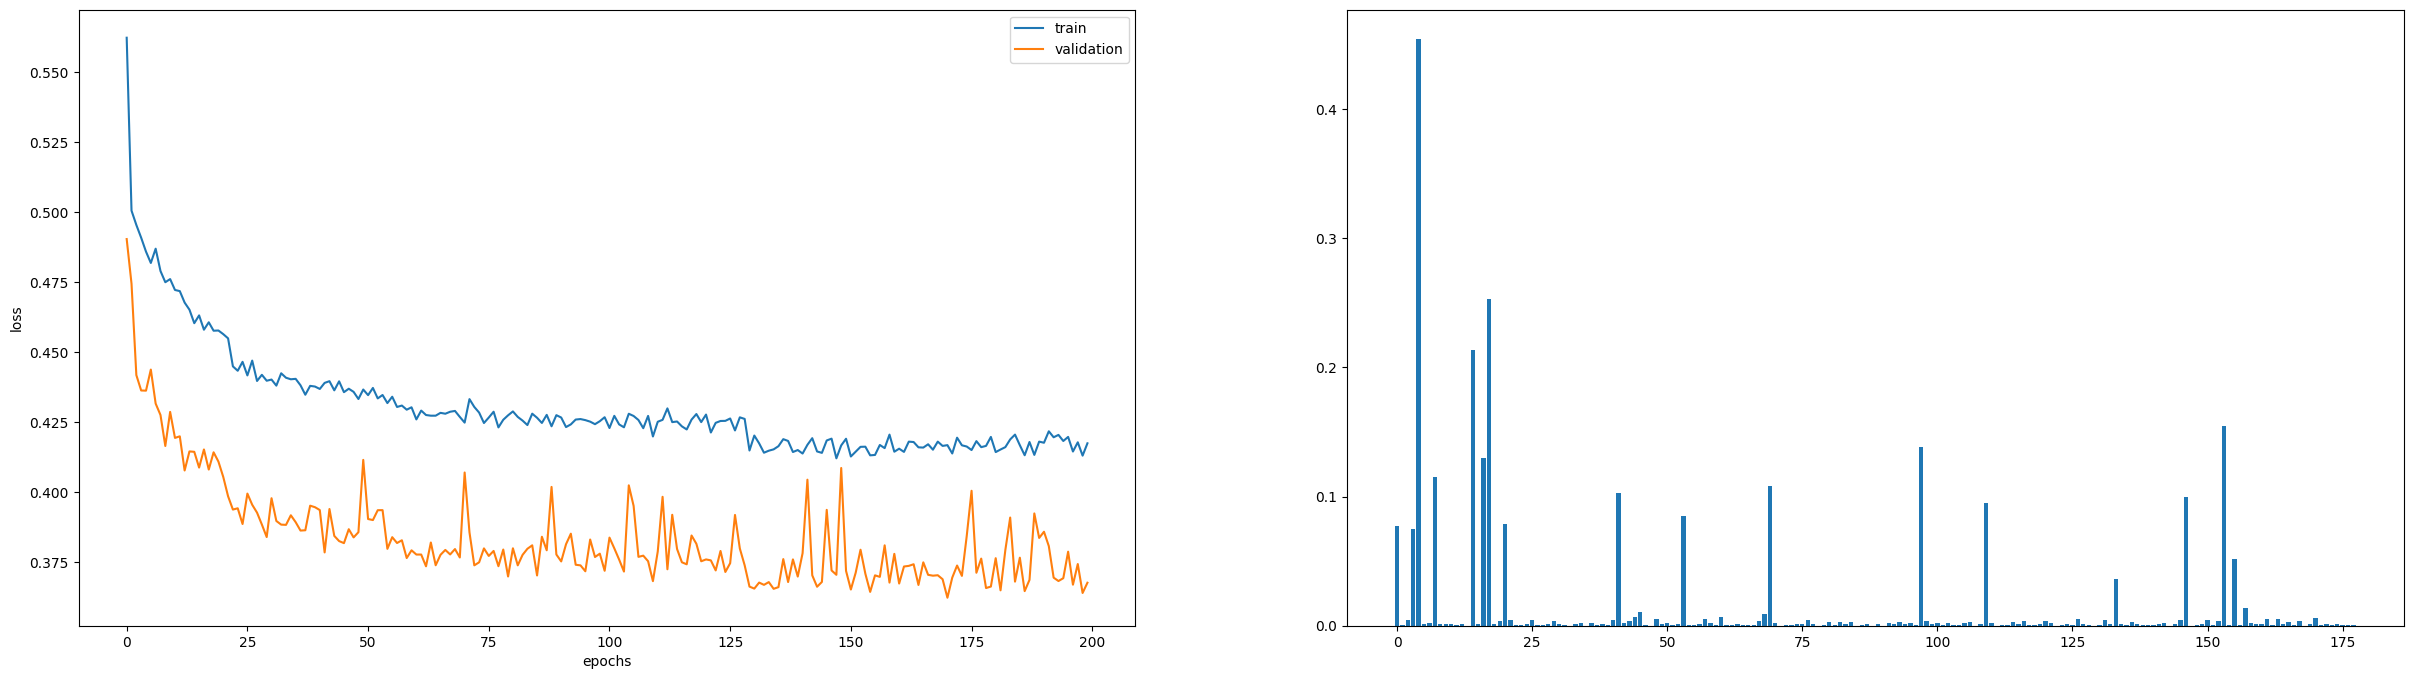

Se han eliminado 157 columnas con red neuronal específicamente: ['Infraction_CGP', 'Base_7744', 'Expenditure_JIG', 'Infraction_SNZ', 'Infraction_SBF', 'Infraction_ZWWJ', 'Infraction_QJJF', 'Base_76065', 'Base_6872', 'Infraction_FMXQ', 'Base_1165', 'Base_39598', 'Infraction_CLLY', 'Infraction_ZTNC', 'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Payment_22507', 'Base_9516', 'Infraction_GWL', 'Expenditure_YTR', 'Base_36384', 'Expenditure_FIP', 'Infraction_PAS', 'Risk_0003', 'Expenditure_HMO', 'Base_24406', 'Expenditure_LMSR', 'Infraction_GEL', 'Base_14808', 'Risk_8065', 'Expenditure_KMW', 'Base_1039', 'Infraction_HSSU', 'Infraction_EHZP', 'Infraction_TBP', 'Base_0580', 'Expenditure_RGD', 'Infraction_PBC', 'Infraction_AQO', 'Base_0229', 'Base_8318', 'Base_91828', 'Infraction_HPS', 'Base_6852', 'Infraction_CLH', 'Expenditure_IDZ', 'Risk_1475', 'Expenditure_BWX', 'Base_8511', 'Infraction_JYZB', 'Base_22178', 'Infraction_ZTYG', 'Infraction_ZVW', 'Infraction_EYU', 'Expenditure_UWVG', 'Infract

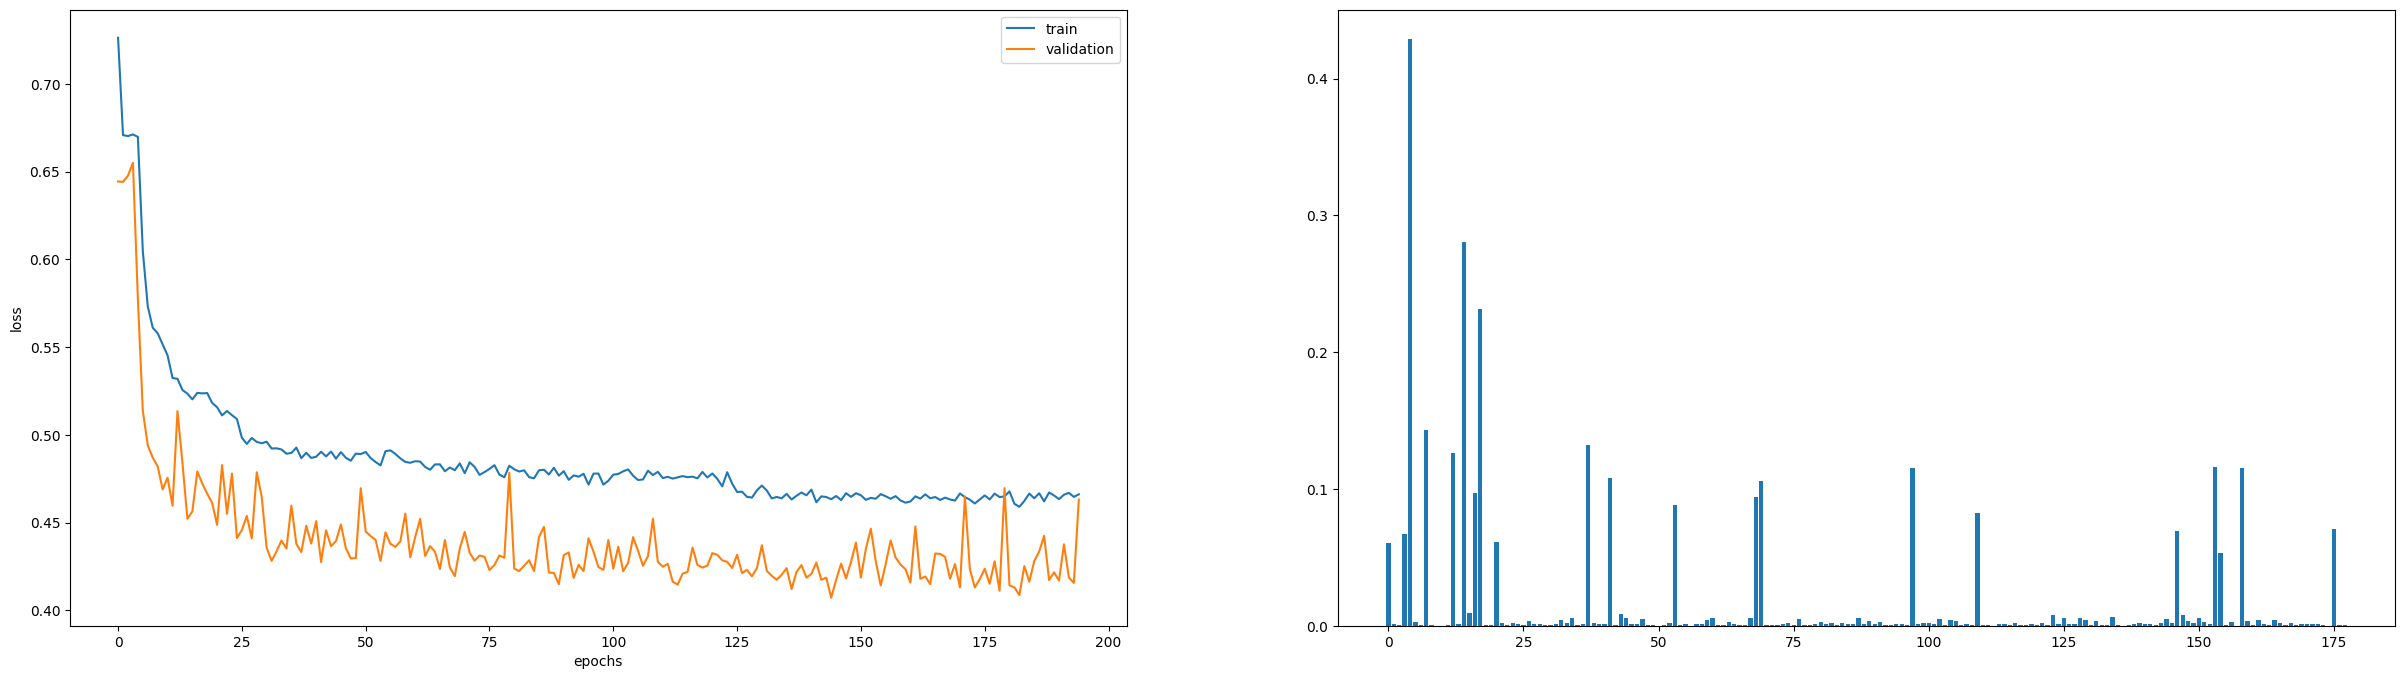

In [ ]:
set_seed(34)
dfNN = FSNN(df)
dfNN_over = FSNN(df_over)

df3['NeuralNetwork'] = dfNN
df3_over['NeuralNetwork'] = dfNN_over
with open('df3_columns.pkl','wb') as file:
    pickle.dump(df3, file, pickle.HIGHEST_PROTOCOL)

with open('df3_over_columns.pkl','wb') as file:
    pickle.dump(df3_over, file, pickle.HIGHEST_PROTOCOL)